In [13]:
import os
import numpy as np
import tensorflow as tf
from collections import Counter 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras.layers import Input
import matplotlib.pyplot as plt 

In [14]:
data_dir = "../Dogs"
class_names = [
    "Affenpinscher", "Airedale", "Appenzeller", "Basenji", "Basset", "Beagle", 
    "Bloodhound", "Bluetick", "Borzoi", "Boxer", "Briard", "Bull", "Cairn", 
    "Cardigan", "Chihuahua", "Chow", "Clumber", "Collie", "Dhole", "Dingo", 
    "Doberman", "EntleBucher", "Groenendael", "Husky", "Keeshond", "Kelpie", 
    "Komondor", "Kuvasz", "Leonberg", "Lhasa", "Malamute", "Malinois", 
    "Otterhound", "Papillon", "Pekinese", "Pembroke", "Pomeranian", "Pug", 
    "Redbone", "Rottweiler", "Saluki", "Samoyed", "Schipperke", "Vizsla", 
    "Weimaraner", "Whippet"
]




img_height, img_width = 224, 224
batch_size = 32



Found 6303 images belonging to 46 classes.
Found 1558 images belonging to 46 classes.
Số lượng mẫu trong tập huấn luyện: 6303
Số lượng mẫu trong tập kiểm tra: 1558
Số lượng class trong dữ liệu: 46
Danh sách class: dict_keys(['Affenpinscher', 'Airedale', 'Appenzeller', 'Basenji', 'Basset', 'Beagle', 'Bloodhound', 'Bluetick', 'Borzoi', 'Boxer', 'Briard', 'Bull', 'Cairn', 'Cardigan', 'Chihuahua', 'Chow', 'Clumber', 'Collie', 'Dhole', 'Dingo', 'Doberman', 'EntleBucher', 'Groenendael', 'Husky', 'Keeshond', 'Kelpie', 'Komondor', 'Kuvasz', 'Leonberg', 'Lhasa', 'Malamute', 'Malinois', 'Otterhound', 'Papillon', 'Pekinese', 'Pembroke', 'Pomeranian', 'Pug', 'Redbone', 'Rottweiler', 'Saluki', 'Samoyed', 'Schipperke', 'Vizsla', 'Weimaraner', 'Whippet'])


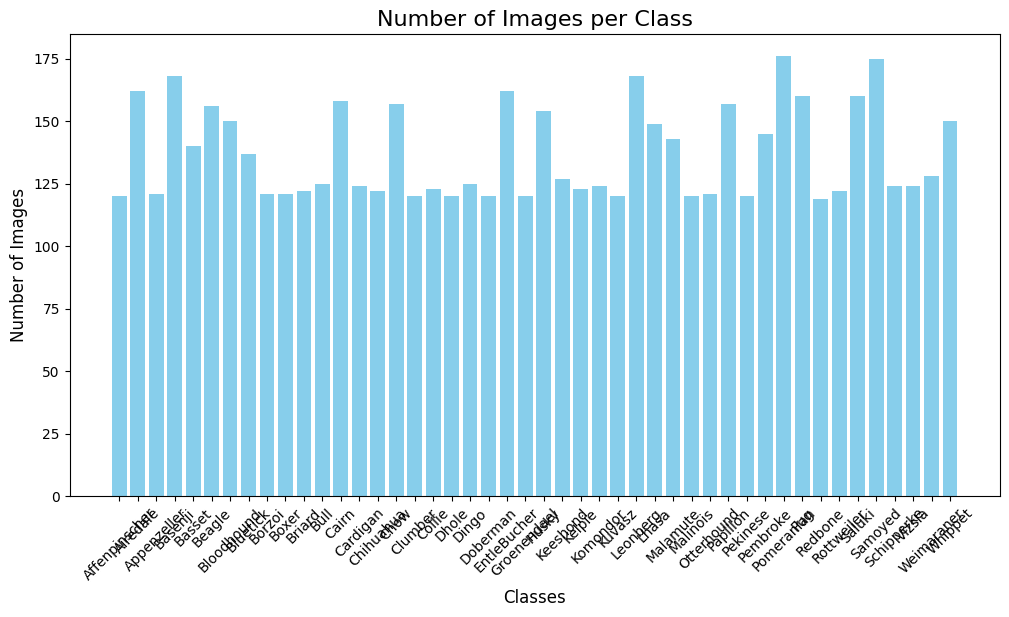

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    horizontal_flip=True
)

train_data_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_data_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print(train_data_gen.class_indices)
print(validation_data_gen.class_indices)


In [ ]:
img_height, img_width = 224, 224
num_classes = 46

# Use MobileNetV2 as the base model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')


for layer in base_model.layers[:-5]:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)


history = model.fit(
    train_data_gen,
    epochs=50,
    validation_data=validation_data_gen,
    callbacks=[early_stopping, reduce_lr]
)


In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_data_gen)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation accuracy: {accuracy * 100:.2f}%")

plt.figure(figsize=(14, 6))

# Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
# Save the model
model.save("models/dog_breeds_classifier_model.h5")
